In [3]:
import pandas as pd
import numpy as np
import networkx as nx

In [4]:
main_titles = pd.DataFrame(pd.read_csv("data/National Academies Report References.csv", header=0))
main_titles

,TITLE
0,Human influenza resulting from aerosol inhalation
1,Influenza A virus is transmissible via aerosol...
2,Turbulent gas clouds and respiratory pathogen ...
3,Effects of a “new” human respiratory virus in ...
4,The time course of the immune response to expe...
5,Short-range airborne route dominates exposure ...
6,Detection of air and surface contamination by ...
7,MERS-CoV spike nanoparticles protect mice from...
8,Impact assessment of non-pharmaceutical interv...
9,Pathogenicity of severe acute respiratory coro...


In [5]:
searched_data = pd.DataFrame(pd.read_csv("data/extracted_scopus_data.csv", header=0))
searched_data

,Title,Abstract,Number of results,Reference Titles
0,Human Influenza Resulting from Aerosol Inhalation,Volunteers were given A2 influenza virus in a ...,1,[None]
1,Influenza A virus is transmissible via aerosol...,"© 2020, The Author(s).Influenza viruses are pr...",1,['Estimates of global seasonal influenza-assoc...
2,Turbulent Gas Clouds and Respiratory Pathogen ...,NaN,1,['Visualization of sneeze ejecta: Steps of flu...
3,Effects of a “New” Human Respiratory Virus in ...,"A virus, 229-E, which morphologically resemble...",1,[None]
4,The time course of the immune response to expe...,"After preliminary trials, the detailed changes...",1,['The role of nasal secretion and serum antibo...
...,...,...,...,...
64,Cardiac manifestations in COVID-19 patients—A ...,© 2020 The Authors. Journal of Cardiac Surgery...,12,['Clinical features of patients infected with ...
65,COVID-19 and the cardiovascular system: A revi...,© 2020As the severe acute respiratory syndrome...,12,"['COVID-19, SARS and MERS: are they closely re..."
66,COVID-19 and the cardiovascular system: Implic...,© 2020 Oxford University Press. All rights res...,12,['An interactive web-based dashboard to track ...
67,At the heart of COVID-19,© 2020 Wiley Periodicals LLCCoronavirus diseas...,12,['Identification of a novel coronavirus causin...


In [6]:
searched_data[['Reference Titles']]

,Reference Titles
0,[None]
1,['Estimates of global seasonal influenza-assoc...
2,['Visualization of sneeze ejecta: Steps of flu...
3,[None]
4,['The role of nasal secretion and serum antibo...
...,...
64,['Clinical features of patients infected with ...
65,"['COVID-19, SARS and MERS: are they closely re..."
66,['An interactive web-based dashboard to track ...
67,['Identification of a novel coronavirus causin...


In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
title_list = main_titles.values.tolist()
title_list = [item for sublist in title_list for item in sublist]
title_list

['Human influenza resulting from aerosol inhalation',
 'Influenza A virus is transmissible via aerosolized fomites',
 'Turbulent gas clouds and respiratory pathogen emissions: Potential implications for reducing transmission of COVID-19',
 'Effects of a “new” human respiratory virus in volunteers',
 'The time course of the immune response to experimental coronavirus infection of man',
 'Short-range airborne route dominates exposure of respiratory infection during close contact',
 'Detection of air and surface contamination by SARS-CoV-2 in hospital rooms of infected patients',
 'MERS-CoV spike nanoparticles protect mice from MERS-CoV infection',
 'Impact assessment of non-pharmaceutical interventions against coronavirus disease 2019 and influenza in Hong Kong: An observational study',
 'Pathogenicity of severe acute respiratory coronavirus deletion mutants in hACE-2 transgenic mice',
 'Persistence of severe acute respiratory syndrome coronavirus 2 in aerosol suspensions',
 'Community a

In [10]:
def create_matrix(data_list):
    data_matrix = []

    for i in range(0, len(data_list)-1):
        data_matrix.append(data_list[i:len(data_list)] + data_list[:i])

    return data_matrix

np.shape(create_matrix(title_list))

(40, 41)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similiarity(data_list):
    op = []
    sentence_embeddings = model.encode(data_list)
    for index, main in enumerate(sentence_embeddings):
        if index + 1 < len(sentence_embeddings):
            op.append(round(cosine_similarity([main], [sentence_embeddings[index + 1]])[0][0], 5))
            
    return op

In [12]:
relatedness_matrix_titles = []

for i in create_matrix(title_list):
    relatedness_matrix_titles.append(compute_similiarity(i))

relatedness_matrix_titles

[[0.89539,
  0.66909,
  0.55809,
  0.67009,
  0.40082,
  0.45297,
  0.50525,
  0.45709,
  0.52545,
  0.64021,
  0.45425,
  0.30596,
  0.59059,
  0.27583,
  0.30638,
  0.47878,
  0.39419,
  0.45337,
  0.22446,
  0.4909,
  0.63657,
  0.54001,
  0.49361,
  0.67955,
  0.66933,
  0.67488,
  0.37229,
  0.36549,
  0.48821,
  0.44878,
  0.32976,
  0.36396,
  0.4424,
  0.28612,
  0.54439,
  0.1492,
  0.56165,
  0.65524,
  0.44861,
  0.31313],
 [0.66909,
  0.55809,
  0.67009,
  0.40082,
  0.45297,
  0.50525,
  0.45709,
  0.52545,
  0.64021,
  0.45425,
  0.30596,
  0.59059,
  0.27583,
  0.30638,
  0.47878,
  0.39419,
  0.45337,
  0.22446,
  0.4909,
  0.63657,
  0.54001,
  0.49361,
  0.67955,
  0.66933,
  0.67488,
  0.37229,
  0.36549,
  0.48821,
  0.44878,
  0.32976,
  0.36396,
  0.4424,
  0.28612,
  0.54439,
  0.1492,
  0.56165,
  0.65524,
  0.44861,
  0.31313,
  0.47501],
 [0.55809,
  0.67009,
  0.40082,
  0.45297,
  0.50525,
  0.45709,
  0.52545,
  0.64021,
  0.45425,
  0.30596,
  0.59059,
  0

In [13]:
searched_data = searched_data.dropna()
searched_data[['Abstract']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 67
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Abstract  60 non-null     object
dtypes: object(1)
memory usage: 960.0+ bytes


In [14]:
abstract_list = searched_data[['Abstract']].values.tolist()
abstract_list = [item for sublist in abstract_list for item in sublist]

for index, item in enumerate(abstract_list):
    if item.startswith('©'):
        abstract_list[index] = item[2:]


abstract_list

['Volunteers were given A2 influenza virus in a small-particle aerosol. Infection and typical influenza resulted from low doses of virus administered in this manner. Low levels of serum neutralizing antibody were not completely effective in preventing infection and illness. The human infectious dose of this influenza strain when administered by aerosol to subjects free of serum neutralizing antibody was approximately 3 TCID50. Gratitude is expressed to Dr. David W. Ailing for assistance with the statistics and in calculating dosages; Mr. Edward W. Harvey, Mr. Irven B. Stacy, Mr. Leonard P. Durocher, and Mr. James Turner for technical assistance; and Mr. Edward P. Derren-bacher aand Mr. Charles O. Masemore for assistance with volunteer inoculations. © 1966, SAGE Publications. All rights reserved.',
 '2020, The Author(s).Influenza viruses are presumed, but not conclusively known, to spread among humans by several possible routes. We provide evidence of a mode of transmission seldom consi

In [15]:
np.shape(create_matrix(abstract_list))

(59, 60)

In [16]:
relatedness_matrix_abstract = []

for i in create_matrix(abstract_list):
    relatedness_matrix_abstract.append(compute_similiarity(i))

np.shape(relatedness_matrix_abstract)

(59, 59)

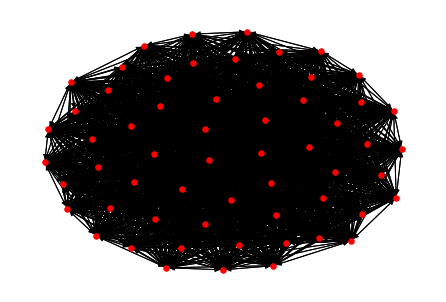

In [17]:
relatedness_matrix_abstract = np.matrix(relatedness_matrix_abstract)
relatedness_graph_abstract = nx.from_numpy_matrix(relatedness_matrix_abstract, create_using=nx.MultiDiGraph)
pos = nx.spring_layout(relatedness_graph_abstract, seed=4321, k=0.5)
nx.draw(relatedness_graph_abstract, pos=pos, node_size=30, node_color='red')

In [18]:
import matplotlib.pyplot as plt
def plot_matrix(list_data, matrix_data):
    labels = []
    for var in list_data:
        labels.append(var.split(" ")[:5])

    fig, ax = plt.subplots(figsize=(20,20))
    cax = ax.matshow(matrix_data, interpolation='nearest')
    ax.grid(True)
    plt.title('Relatedness Matrix Titles')
    plt.xticks(range(np.shape(create_matrix(list_data))[1]), labels, rotation=90);
    plt.yticks(range(np.shape(create_matrix(list_data))[1]), labels);
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
    plt.show()

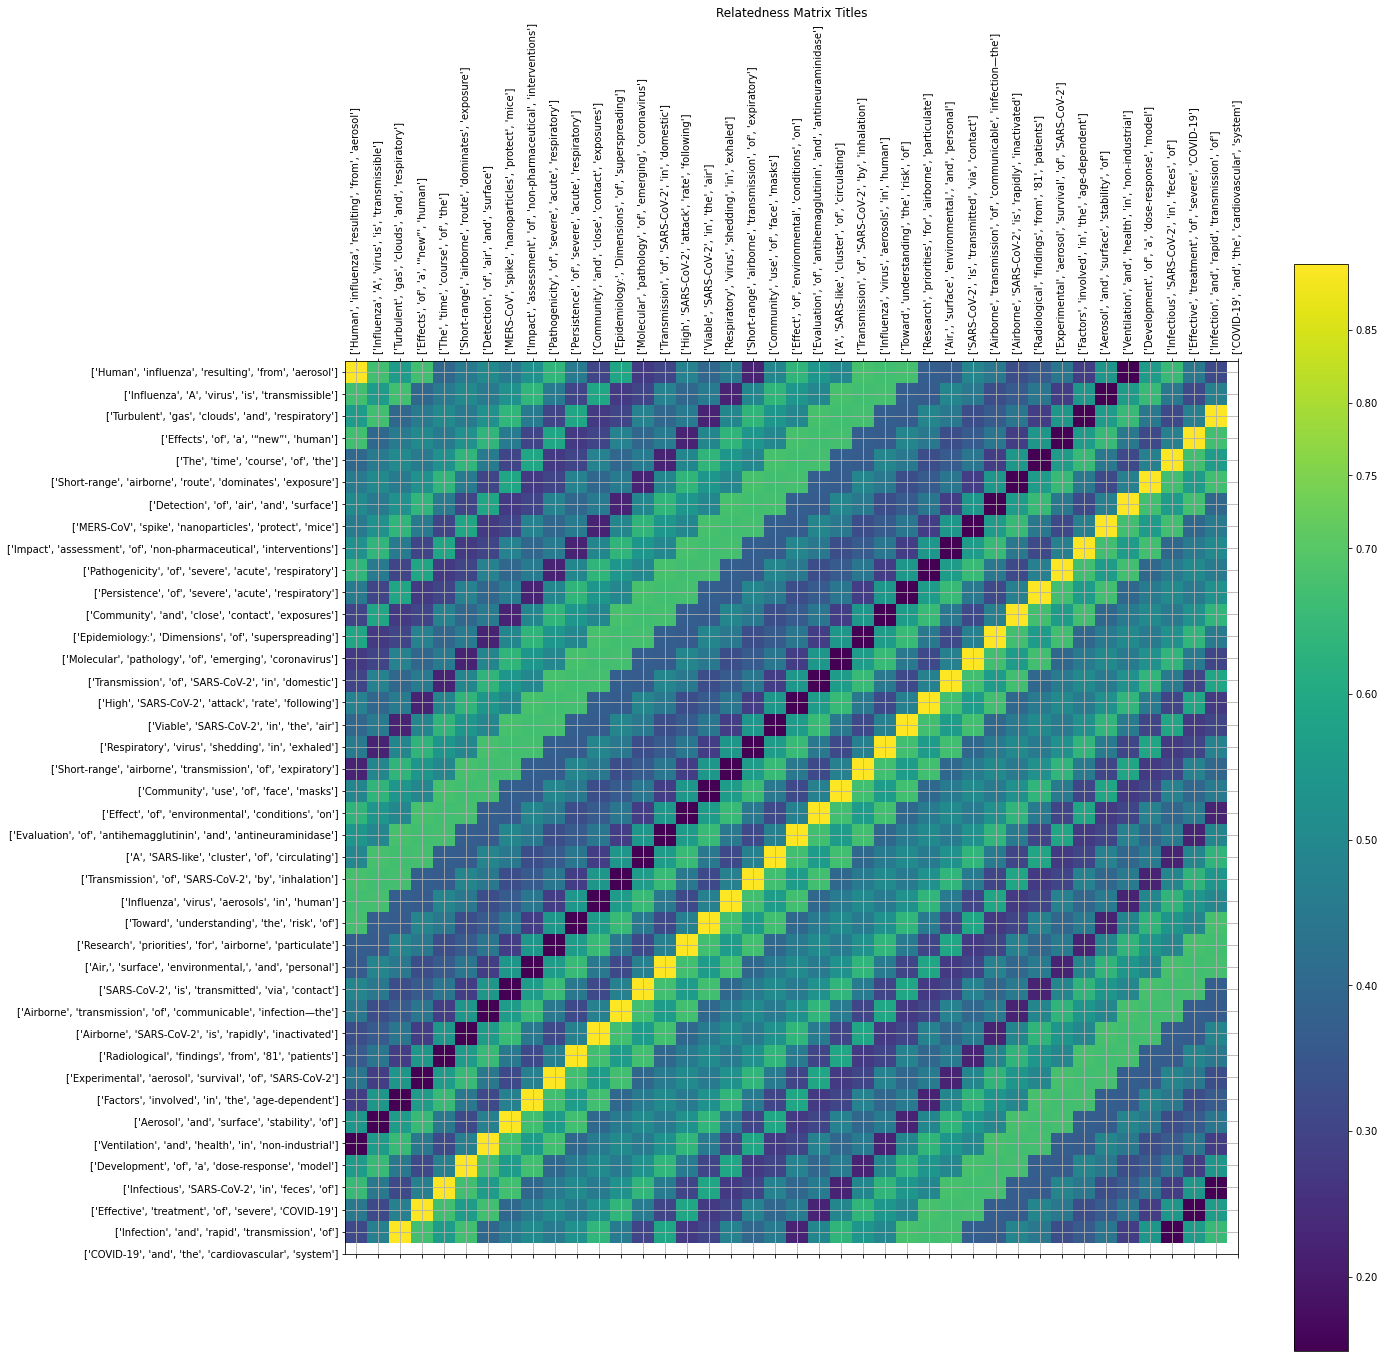

In [19]:
plot_matrix(title_list, relatedness_matrix_titles)

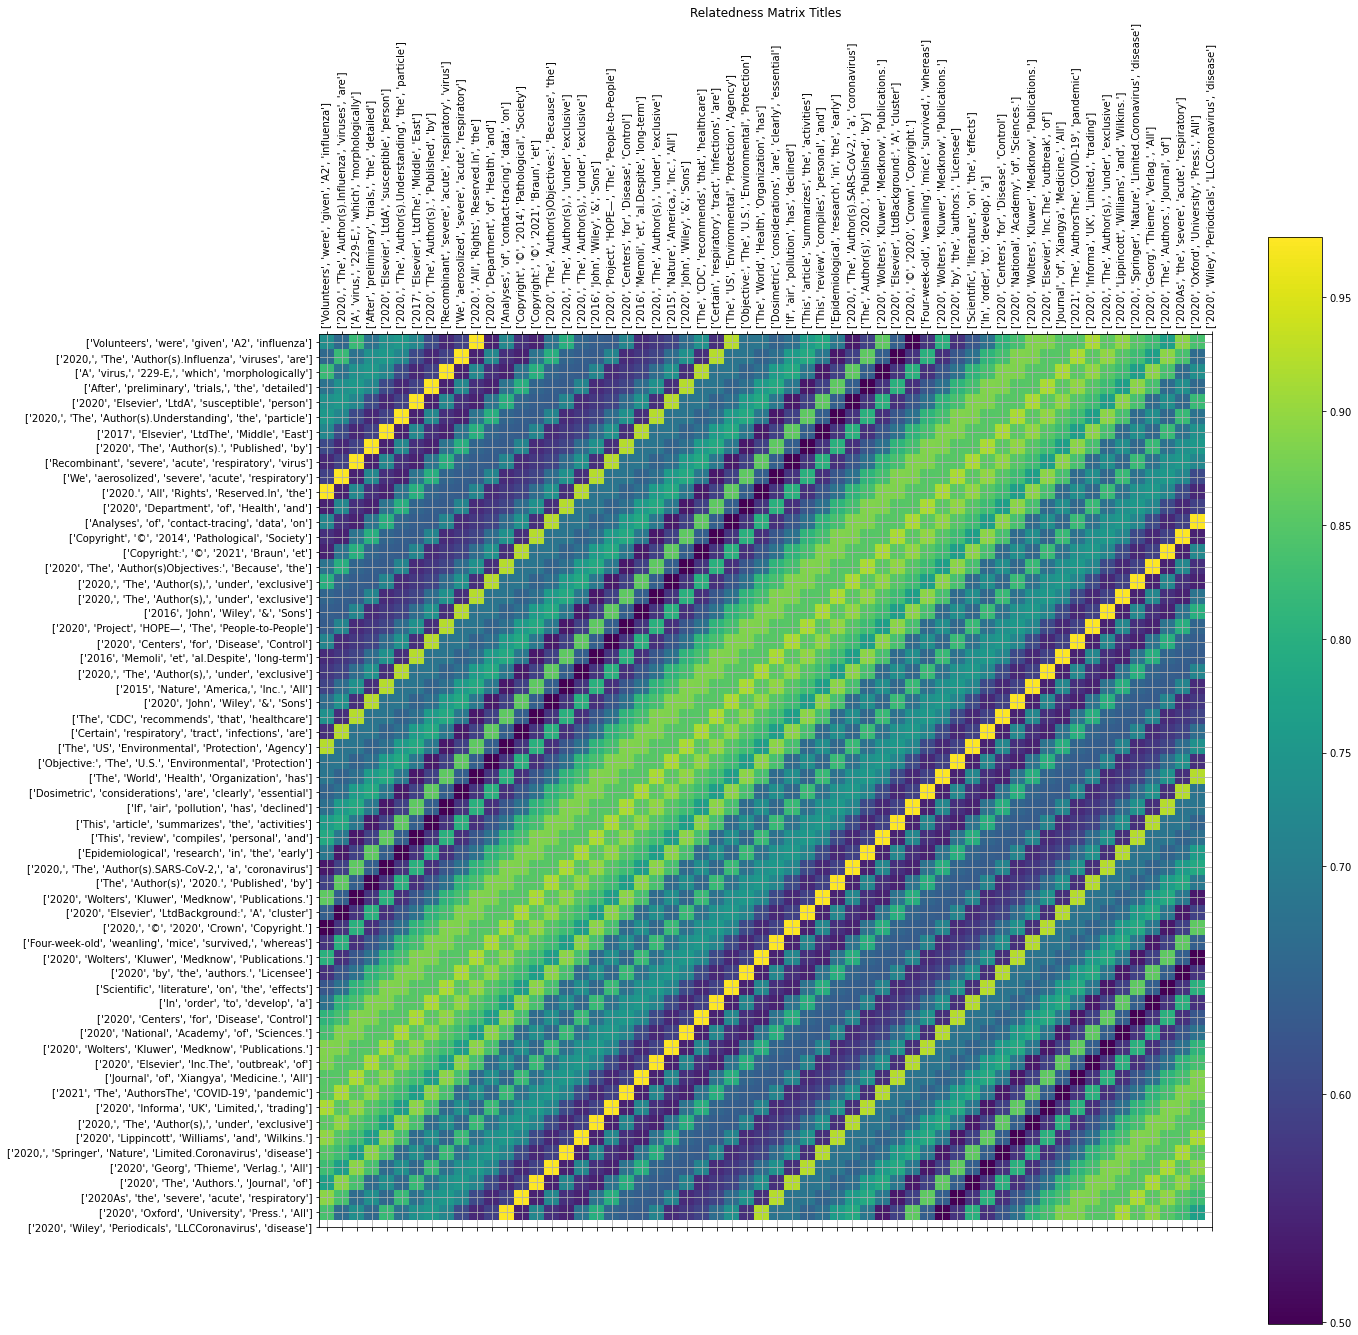

In [20]:
plot_matrix(abstract_list, relatedness_matrix_abstract)